使用机器学习模型进行交易
本教程将展示如何使用backtesting.py框架训练和回溯测试机器学习价格预测模型。假设您已经熟悉基本的框架用法和一般的机器学习。
在本教程中，我们将使用近一年的每小时欧元/美元外汇数据样本

In [1]:
from backtesting.test import EURUSD, SMA

data = EURUSD.iloc[:, :-1].copy()

print(data.info, data.info())


C:\ProgramData\Anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2017-04-19 09:00:00 to 2018-02-07 15:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5000 non-null   float64
 1   High    5000 non-null   float64
 2   Low     5000 non-null   float64
 3   Close   5000 non-null   float64
dtypes: float64(4)
memory usage: 195.3 KB
<bound method DataFrame.info of                         Open     High      Low    Close
2017-04-19 09:00:00  1.07160  1.07220  1.07083  1.07219
2017-04-19 10:00:00  1.07214  1.07296  1.07214  1.07260
2017-04-19 11:00:00  1.07256  1.07299  1.07170  1.07192
2017-04-19 12:00:00  1.07195  1.07280  1.07195  1.07202
2017-04-19 13:00:00  1.07200  1.07230  1.07045  1.07050
...                      ...      ...      ...      ...
2018-02-07 11:00:00  1.23390  1.23548  1.23386  1.23501
2018-02-07 12:00:00  1.23501  1.23508  1.23342  1.23422
2018-02-07 13:00:00  1.23422  1.23459  1.23338  1.23372
20

在监督式机器学习中，我们尝试学习一个将输入特征向量（自变量）映射到已知输出值（因变量）的函数：

$$ f\colon X \to \mathbf{y} $$

这样，只要我们的模型函数足够，我们就可以从新获取的输入特征向量中预测未来的输出值，从而达到一定程度的确定性。在我们的示例中，我们将尝试在未来两天内将几个价格派生的特征和常见的技术指标映射到价格点。我们构建模型设计矩阵$X$下面:

In [2]:
data['X_Open'] = data.Open
# data['X_High'] = data.High
# data['X_Low'] = data.Low
data['X_Close'] = data.Close
data = data.dropna().astype(float)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2017-04-19 09:00:00 to 2018-02-07 15:00:00
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     5000 non-null   float64
 1   High     5000 non-null   float64
 2   Low      5000 non-null   float64
 3   Close    5000 non-null   float64
 4   X_Open   5000 non-null   float64
 5   X_Close  5000 non-null   float64
dtypes: float64(6)
memory usage: 273.4 KB
None


Classification accuracy:  0.8224
(5000, 2) 2 (5000,) 1


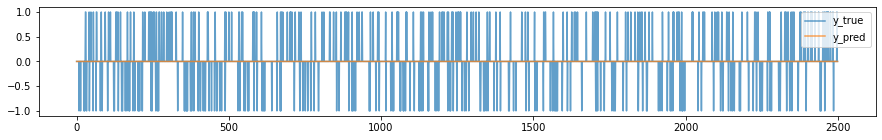

In [3]:
import numpy as np
#设定numpy显示浮点数精度的小数位数,不使用科学记数法
np.set_printoptions(precision=4, suppress=True)

def get_X(data):
    """返回模型设计矩阵 X"""
    X = data.filter(like='X').values
    # print(X.shape, X.ndim)
    return X


def get_y(data):
    """返回因变量 y
    # 收盘价>开盘价 标记类别为1 收盘价<开盘价 标记类别为-1 收盘价=开盘价 标记类别为0
    """
    epsilon = 0.001  #误差
    y = (data.Close - data.Open) / data.Open
    y[y.between(-epsilon, epsilon)] = 0  # 货币贬值的回报率低于epsilon
    y[y > 0] = 1
    y[y < 0] = -1
    # print(y.shape, y.ndim)
    return y


def get_clean_Xy(df):
    """返回(X, y)已清除的NaN值"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    # print(X.shape, X.ndim, y.shape, y.ndim)
    return X, y


'''
让我们看看我们的数据如何使用来自最先进的scikit-learn Python机器学习包的简单k-最近邻（kNN）算法进行建模。 Let’s see how our data performs modeled using a simple k-nearest neighbors (kNN) algorithm from the state of the art scikit-learn Python machine learning package. To avoid (or at least demonstrate) overfitting, 为了避免（或至少演示）过拟合，总是将数据拆分为训练集和测试集;特别是，不要在构建模型的相同数据上验证模型性能。
'''
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

# clf = KNeighborsClassifier(7)  #
clf = SVC(kernel='linear', C=1, gamma='scale', probability=False)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))
print(X.shape, X.ndim, y.shape, y.ndim)


In [4]:
sv_ = clf.support_vectors_
sv_mean = np.mean(sv_)
sv_av = (sv_mean / (sv_.shape[0] * sv_.shape[1]))
print('sv_s:', sv_.shape,
      'sv_:', sv_[:1, ], )
print('sv_av:%.5f' % (sv_mean / (sv_.shape[0] * sv_.shape[1])),
      'sv_std:%.5f' % np.std(sv_),  #标准差
      'av/std:%.5f' % (sv_av / np.std(sv_)),
      'sv_mean:%.5f' % sv_mean,
      )
print('X:', X[:])

sv_s: (864, 2) sv_: [[1.118 1.116]]
sv_av:0.00068 sv_std:0.05170 av/std:0.01311 sv_mean:1.17135
X: [[1.0716 1.0722]
 [1.0721 1.0726]
 [1.0726 1.0719]
 ...
 [1.2342 1.2337]
 [1.2337 1.2343]
 [1.2343 1.229 ]]


In [5]:
# 通过传递值列表创建
np.random.seed(0)
d1 = np.array(np.random.randint(-2, 3, 2))
d2 = np.array(np.arange(6))
print(type(d1), d1.shape, d2.shape)
print(d1, d2)

for i,v in enumerate(d2):
    d2[i] = np.min(abs(d1 - v)) + v
    print(np.min(abs(d1 - v)), end=',')
print()
print(d2)

<class 'numpy.ndarray'> (2,) (6,)
[ 2 -2] [0 1 2 3 4 5]
2,1,0,1,2,3,
[2 2 2 4 6 8]


In [7]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply


def svc(array, n):
    # print(type(array), array.shape, array.ndim)
    df = array.iloc[:n]
    X, y = get_clean_Xy(df)
    # 初始化我们的模型，分类器
    clf = SVC(kernel='linear', C=100, gamma='scale', probability=False)

    clf.fit(X, y)
    sv_ = clf.support_vectors_

    close = array.Close
    sv_c = np.zeros(len(close), dtype=close.dtype)
    for i, v in enumerate(close):
        sv_min = np.min(abs(sv_ - v))
        sv_c[i] = sv_min + v
    print(type(sv_c), sv_c.shape, sv_c.ndim)
    return pd.Series(sv_c)


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%
    d_svc = 100

    def __init__(self, broker, data, params):
        super().__init__(broker, data, params)
        self.daily_svc = None
        # self.forecasts = None
        # self.sv_c = None
        # self.sv_ = None
        # self.clf = None

    def init(self):
        # 在init()和next()中，调用超方法来正确初始化父类是很重要的
        super().init()

        # 为了构建每日svc，我们可以使用库中的' resample_apply() ' helper函数
        self.daily_svc = resample_apply(
            'D', svc, data, self.d_svc)

        # self.sv_c = self.I(sv_cc(self.data, sv_), name='sv_c')
        # self.sv_c = self.I(svc, self.data.Close, sv_)
        pass

    def next(self):
        # 跳过训练、样本内数据
        # if len(self.data) < N_TRAIN:
        #     return

        # 如果sma1交叉高于sma2，关闭所有现有的空头交易，并买入该资产
        if crossover(self.data.Close, self.daily_svc):
            self.position.close()
            self.buy()

        # 否则，如果sma1交叉低于sma2，关闭所有现有的多头交易，并出售资产
        elif crossover(self.daily_svc, self.data.Close):
            self.position.close()
            self.sell()


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()


<class 'numpy.ndarray'> (251,) 1


Start                     2017-04-19 09:00:00
End                       2018-02-07 15:00:00
Duration                    294 days 06:00:00
Exposure Time [%]                        95.3
Equity Final [$]                          0.0
Equity Peak [$]                  10840.266191
Return [%]                             -100.0
Buy & Hold Return [%]               14.628937
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              522.204155
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -33.851451
Max. Drawdown Duration      293 days 07:00:00
Avg. Drawdown Duration       97 days 20:00:00
# Trades                                  432
Win Rate [%]                             25.0
Best Trade [%]                        1.49663
Worst Trade [%]                     -5.013021
Avg. Trade [%]                    

In [ ]:
import pandas as pd
from backtesting.lib import SignalStrategy, TrailingStrategy


class SmaCross(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25

    def init(self):
        # 在init()和next()中，调用超方法来正确初始化父类是很重要的
        super().init()

        # 预先计算两个移动平均线
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)

        # sma1和sma2向上交叉。Diff给出[-1,0，*1*]
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)  # Upwards/long only

        # 在每个订单上使用95%的可用流动性(当时)。(保留值为1。而是只买一股。)
        entry_size = signal * .95

        # 使用' SignalStrategy '提供的方法设置订单输入大小。看文档。
        self.set_signal(entry_size=entry_size)

        # 使用' TrailingStrategy '提供的方法将跟踪止损设置为2倍ATR
        self.set_trailing_sl(2)